# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from rascil.data_models.parameters import rascil_path
results_dir = rascil_path('test_results')


from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt


from rascil.data_models import PolarisationFrame

from rascil.processing_components import create_visibility, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_2d, predict_2d

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [3]:
lowr3 = create_named_configuration('LOWBD2', rmax=750.0)

create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 750.0 m includes 236 antennas/stations


In [4]:
print(lowr3.xyz)

[[-2566715.76343079  5087507.98933145 -2865249.74542954]
 [-2566917.55774179  5087396.82932732 -2865029.92175911]
 [-2566767.64449879  5087463.93769549 -2865162.63143219]
 [-2566998.42494379  5087461.95681092 -2865158.71414809]
 [-2566815.87583079  5087432.4155484  -2865100.29503586]
 [-2566875.23076279  5087354.89797998 -2864947.00072334]
 [-2566872.40315079  5087406.12723061 -2865048.30876121]
 [-2566860.24566679  5087456.31825995 -2865147.56367199]
 [-2566729.00462579  5087407.55218624 -2865051.12667201]
 [-2567017.05977679  5087413.10529604 -2865062.10818455]
 [-2566960.58228279  5087412.41445943 -2865060.74202555]
 [-2566673.29943079  5087375.24982681 -2864987.24737236]
 [-2566853.29497379  5087483.87357926 -2865202.05549642]
 [-2566810.78114779  5087471.64931766 -2865177.88149542]
 [-2566900.85365779  5087430.21656409 -2865095.94645017]
 [-2567080.43813779  5087435.2210518  -2865105.84303902]
 [-2566807.56738579  5087396.35602863 -2865028.98579068]
 [-2566678.97956679  5087404.69

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 27730 rows, 0.003 GB
create_visibility: flagged 0/27730 visibilities below elevation limit 0.261799 (rad)


In [6]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, wprojection_planes=1, 
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 383.3 (wavelengths)
advise_wide_field: Maximum w 125.8 (wavelengths)
advise_wide_field: Station/dish diameter 35.0 (meters)
advise_wide_field: Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: Image field of view 0.257 (rad) 14.7 (deg) 5.3e+04 (asec)
advise_wide_field: Synthesized beam 0.00261 (rad) 0.149 (deg) 538 (asec)
advise_wide_field: Cellsize 0.000652 (rad) 0.0374 (deg) 135 (asec)
advice_wide_field: Npixels per side = 394
advice_wide_field: Npixels (power of 2) per side = 512
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: Npixels (power of 2, 3, 4, 5) per side = 396
advice_wide_field: W sampling for full image = 2.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 19.4 (wavelengths)
advice_wide_field: Time sampling for full image = 154.7 (s)
advice_wide_field: Time sampling 

Plot the synthesized uv coverage.

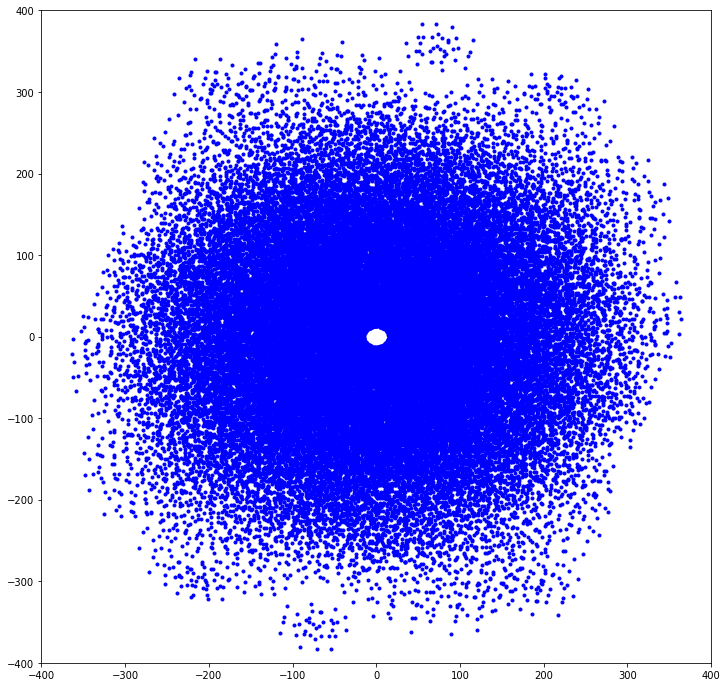

In [7]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.xlim([-400.0, 400.0])
plt.ylim([-400.0, 400.0])
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/rascil/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)


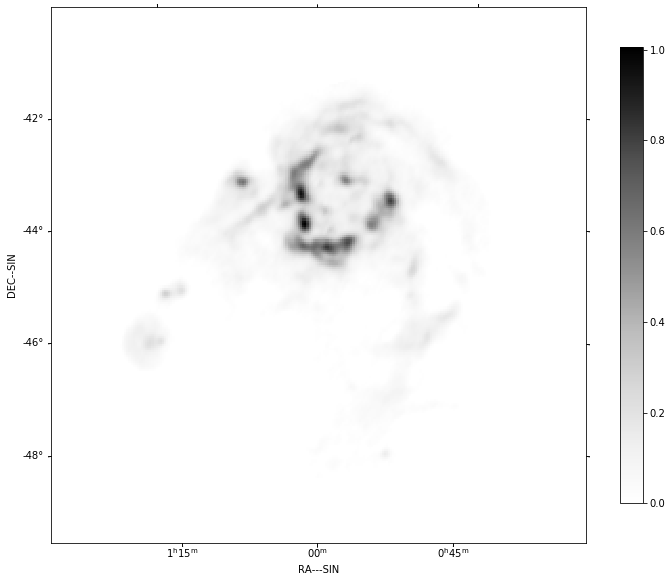

In [8]:
m31image = create_test_image(frequency=frequency, cellsize=cellsize)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)

fig=show_image(m31image)

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.94718025, -44.96261426)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


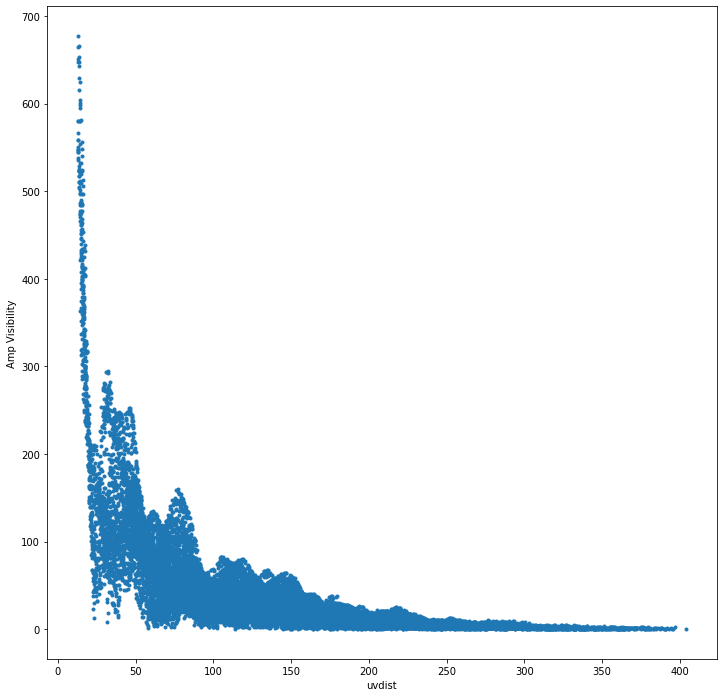

In [9]:
vt = predict_2d(vt, m31image, context='2d')

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 363.929962 wavelengths
create_image_from_visibility: Critical cellsize = 0.001374 radians, 0.078718 degrees
create_image_from_visibility: Cellsize          = 0.000652292 radians, 0.0373736 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 14.038234, -3.421978, sumwt = 27730.000000
Max, min in PSF         = 0.998686, -0.011420, sumwt = 27730.000000


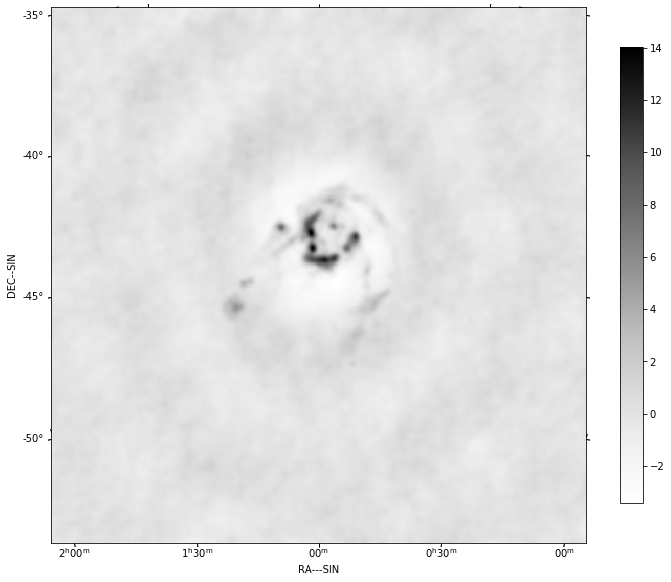

In [10]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=512)
dirty, sumwt = invert_2d(vt, model, context='2d')
psf, sumwt = invert_2d(vt, model, context='2d', dopsf=True)

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : window is inner quarter
deconvolve_cube : Cleaning inner quarter of each sky plane
deconvolve_cube : PSF support = +/- 256 pixels
deconvolve_cube : PSF shape (1, 1, 512, 512)
deconvolve_cube : Multi-scale clean of each polarisation and channel separately
deconvolve_cube : Processing pol 0, channel 0
msclean : Peak of PSF = 0.9986864344421558 at (256, 256)
msclean : Peak of Dirty = 14.038234 Jy/beam at (296, 248) 
msclean : Coupling matrix =
 [[1.         0.97147825 0.65793988 0.16095984]
 [0.97147825 0.94438596 0.64486693 0.16017728]
 [0.65793988 0.64486693 0.48835048 0.14899789]
 [0.16095984 0.16017728 0.14899789 0.09037039]]
msclean : Max abs in dirty Image = 14.056699 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 10000 iterations or peak < 0.014057 (Jy/beam)
msclean : Timing for setup: 0.707 (s) for dirty shape (512, 512), PSF shape (512, 512) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [12.12081175 12.05331642 11.17810257

Text(0.5, 1.0, 'Restored')

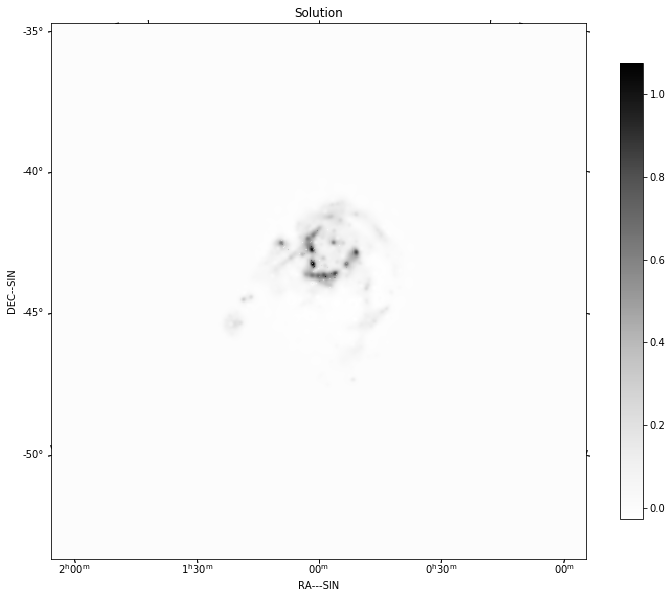

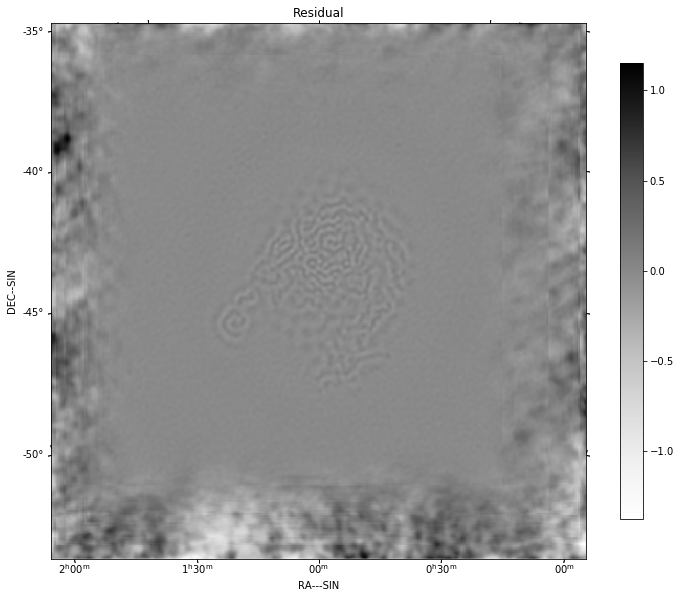

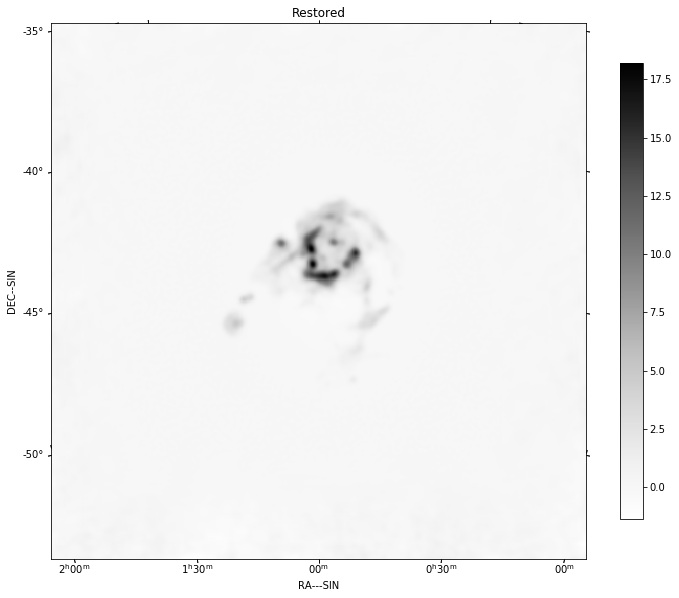

In [11]:
comp, residual = deconvolve_cube(dirty, psf, niter=10000, threshold=0.001, fractional_threshold=0.001,
                                 window_shape='quarter', gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [12]:
vtmodel = create_visibility(lowr3, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_2d(vtmodel, comp, context='2d')

create_visibility: 27730 rows, 0.003 GB
create_visibility: flagged 0/27730 visibilities below elevation limit 0.261799 (rad)


Now we will plot the original visibility and the residual visibility.

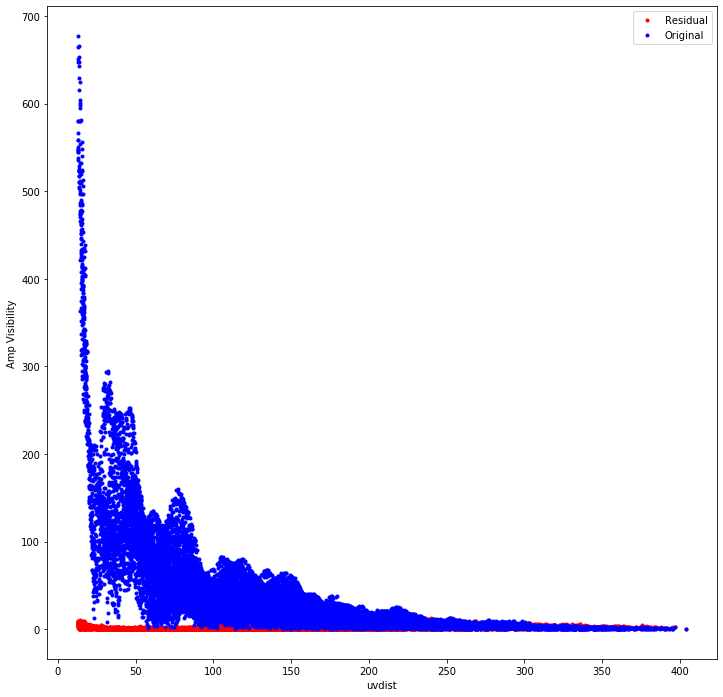

In [13]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', 
         label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()